In [1]:
%cd ..

/home/bnrc2/mu/tf-posegan


In [16]:
import configparser
import os

from dataGenerator.datagen_HG import DataGenerator
from hg_models.ian_hourglass import hourglassnet
from train_class_HG_Tensor_GOU import train_class
import numpy as np

In [3]:
def process_config(conf_file):
    params = {}
    config = configparser.ConfigParser()
    config.read(conf_file)
    for section in config.sections():
        if section == 'DataSetHG':
            for option in config.options(section):
                params[option] = eval(config.get(section, option))
        if section == 'log':
            for option in config.options(section):
                params[option] = eval(config.get(section, option))
        if section == 'Saver':
            for option in config.options(section):
                params[option] = eval(config.get(section, option))
        if section == 'Training setting':
            for option in config.options(section):
                params[option] = eval(config.get(section, option))
    return params

def process_network(conf_file):
    params = {}
    config = configparser.ConfigParser()
    config.read(conf_file)
    for section in config.sections():

        for option in config.options(section):
            params[option] = eval(config.get(section, option))
    return params
params = process_config('./config/config.cfg')
network_params = process_network("./config/hourglass.cfg")

In [4]:
model = hourglassnet(nModules=network_params['nmodules'])
train_data = DataGenerator(imgdir=params["train_img_path"], txt="/media/bnrc2/_backup/dataset/aiclg/data.txt", batch_size=params['batch_size'], is_aug=False,
                           joints_name=
                           params["joints"])  # , refine_num = 10000)
valid_data = DataGenerator(imgdir=params["valid_img_path"], txt="/media/bnrc2/_backup/dataset/aiclg/valid.txt", batch_size=params['batch_size'], is_aug=False,
                           joints_name=
                           params["joints"],isTraing=False)
train_log_dir = "/media/bnrc2/_backup/log/self-gan/HG/train.log"
valid_log_dir = "/media/bnrc2/_backup/log/self-gan/HG/valid.log"

trainer = train_class(model, nstack=network_params['nstack'], batch_size=params['batch_size'],
                              learn_rate=params['lear_rate'], decay=params['decay'],
                              decay_step=params['decay_step'],logdir_train=train_log_dir,
                              logdir_valid=valid_log_dir,name='gan',resume="/media/bnrc2/_backup/models/hg/gan_0",
                               train_record=train_data,valid_record=valid_data,
                              save_model_dir="/media/bnrc2/_backup/models/hg/",#params['model_save_path'],
                              gpu=[0],partnum=network_params['partnum'],
                              val_label=params['valid_label'],train_label=params['label_dir'],
                      human_decay=params['human_decay'],
                     )
trainer.generateModel()

READING TRAIN DATA
SET CREATED
--Training set : 377616  samples.
READING TRAIN DATA
SET CREATED
--Training set : 26390  samples.
/gpu:0


In [5]:
valid_gen = valid_data.get_batch_generator()

In [6]:
trainer.test_init(10)

Session initialization
init done
resume from/media/bnrc2/_backup/models/hg/gan_0
INFO:tensorflow:Restoring parameters from /media/bnrc2/_backup/models/hg/gan_0
________________________________
score = 0.0
________________________________


In [10]:
from tools.keypoint_eval import getScore
from tools.ht2coord import getjointcoord
from tools.keypoint_eval import load_annotations
import time
valid_anno = load_annotations(params['valid_label'])
valid_predictions = dict()
valid_predictions['image_ids'] = []
valid_predictions['annos'] = dict()

gt_begin = time.time()
gt_anno = load_annotations(params['valid_label'])
gt_predictions = dict()
gt_predictions['image_ids'] = []
gt_predictions['annos'] = dict()

for v in range(10):  # valid_iter

    img_valid, gt_valid, name_valid, center_valid, scale_valid = next(
        valid_gen)


    valid_out = trainer.Session.run(
        trainer.valid_output, feed_dict={trainer.valid_img: img_valid, trainer.valid_ht:
            gt_valid}
    )

    # print(np.array(accuracy_pred).shape)
    # valid_predictions = getjointcoord(val_cord, val_name, valid_predictions)
    vadli_coord = trainer.train_record.recoverFromHm(hm=valid_out, center=center_valid,
                                                  scale=scale_valid)
    gt_coord = trainer.train_record.recoverFromHm(hm=gt_valid, center=center_valid,
                                                  scale=scale_valid)
    valid_predictions = getjointcoord(vadli_coord, name_valid, valid_predictions)
    gt_predictions = getjointcoord(gt_coord, name_valid, gt_predictions)
    

score = getScore(valid_predictions, valid_anno)
print("________________________________")
print("score = " + str(score))
print("________________________________")
getScore(gt_predictions, valid_anno)

________________________________
score = 0.0
________________________________


1.0

In [17]:
def compute_oks(anno, predict, delta):
    """Compute oks matrix (size gtN*pN)."""

    anno_count = len(anno['keypoint_annos'].keys())
    #anno_count = len(predict.keys())
    predict_count = len(predict.keys())
    oks = np.zeros((anno_count, predict_count))
    if predict_count == 0:
        return oks.T

    # for every human keypoint annotation
    for i in range(anno_count):
        anno_key = list(anno['keypoint_annos'].keys())[i]
        anno_keypoints = np.reshape(anno['keypoint_annos'][anno_key], (14, 3))
        visible = anno_keypoints[:, 2] == 1
        bbox = anno['human_annos'][anno_key]
        scale = np.float32((bbox[3]-bbox[1])*(bbox[2]-bbox[0]))
        if np.sum(visible) == 0:
            for j in range(predict_count):
                oks[i, j] = 0
        else:
            # for every predicted human
            for j in range(predict_count):
                predict_key = list(predict.keys())[j]
                predict_keypoints = np.reshape(predict[predict_key], (14, 3))
                dis = np.sum((anno_keypoints[visible, :2] \
                    - predict_keypoints[visible, :2])**2, axis=1)
                oks[i, j] = np.mean(np.exp(-dis/2/delta[visible]**2/(scale+1)))

    return oks

In [18]:
def keypoint_eval(predictions, annotations):
    oks_all = []
    oks_num = 0

    # Construct set to speed up id searching.
    prediction_id_set = set(predictions['image_ids'])
    # for every annotation in our test/validation set
    for image_id in annotations['image_ids']:
        # if the image in the predictions, then compute oks
        if image_id in prediction_id_set:

            oks = compute_oks(anno=annotations['annos'][image_id], \
                              predict=predictions['annos'][image_id]['keypoint_annos'], \
                              delta=annotations['delta'])
            # view pairs with max OKSs as match ones, add to oks_all

            oks_all.append( np.max(oks))

            # accumulate total num by max(gtN,pN)
            oks_num += 1  # np.max(oks.shape)
        # else:

            # otherwise report warning
            #return_dict['warning'].append(image_id + ' is not in the prediction JSON file.')
            # # number of humen in ground truth annotations
            # gt_n = len(annotations['annos'][image_id]['human_annos'].keys())
            # # fill 0 in oks scores
            # oks_all = np.concatenate((oks_all, np.zeros((gt_n))), axis=0)
            # # accumulate total num by ground truth number
            # oks_num += gt_n

    # compute mAP by APs under different oks thresholds
    average_precision = []
    oks_all = np.array(oks_all)
    print(oks_all)
    # for threshold in np.linspace(0.1, 0.5, 10):
    #     average_precision.append(np.sum(oks_all > threshold) / np.float32(oks_num))
    average_precision.append(np.sum(oks_all > 0.5) / np.float32(oks_num))
    #average_precision.append(np.sum(oks_all > 0.5) / np.float32(oks_num))
    #return_dict['score'] = np.mean(average_precision)
    
    return np.mean(average_precision)#return_dict

In [19]:
score = keypoint_eval(valid_predictions,valid_anno)

[  1.14761094e-10   3.03899739e-02   5.88615873e-02   4.12114496e-04
   2.61598119e-04   4.31694825e-09   4.87558039e-02   3.68744453e-02
   9.12264449e-16   3.70333567e-05   1.32716339e-02   2.18885956e-04
   8.85853853e-18   3.85308462e-04   1.87708008e-04   1.07480105e-08
   3.06967636e-05   1.15206566e-01   6.85782623e-08   1.63047952e-03
   7.76381784e-02   3.39856623e-02   2.09466842e-04   8.94858064e-06
   1.03564094e-01   5.61048363e-08   6.42997150e-02   3.51459074e-02
   3.51998936e-18   7.38790572e-04   2.90268504e-06   1.41044167e-05
   1.64027101e-02   4.56332119e-03   8.35452285e-04   4.11487463e-02
   2.77763175e-09   2.62430831e-02   2.53915048e-02   1.02852462e-01
   9.44564583e-02   3.46456802e-06   7.01732624e-03   6.40314554e-02
   5.33491661e-03   8.83578390e-02   3.82865328e-10   4.09839689e-02
   1.12336813e-13   6.20610374e-02   4.40544764e-04   2.36489996e-04
   2.83668107e-07   1.78872701e-03   1.63796858e-24   4.35595018e-28
   4.32079666e-02   2.33444595e-02

In [ ]:
valid_predictions["annos"]["069a85d310d9ae851f16a5bc15b41bd1e80b4a3b"]

In [ ]:

print(valid_anno['annos']["069a85d310d9ae851f16a5bc15b41bd1e80b4a3b"])

In [22]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
 img = (img_valid[1,:] * 255).astype(np.uint8)

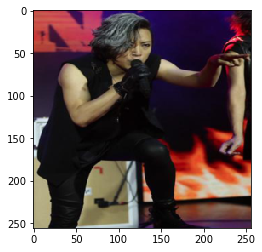

In [34]:
plt.imshow(img)

In [ ]:
img_anno = img.copy()

In [ ]:
hm1 = valid_anno['annos']["069a85d310d9ae851f16a5bc15b41bd1e80b4a3b"]['keypoint_annos']['human2']

In [ ]:
hm1 = np.array(hm1).reshape(-1,3)

In [ ]:
hm1 = hm1.astype(np.int32)

In [ ]:
for i in range(hm1.shape[0]):
    cv2.circle(img_anno,(hm1[i][0],hm1[i][1]),15,(0,0,256),-3)

In [ ]:
plt.imshow(img_anno)

In [ ]:
valid = valid_predictions["annos"]["069a85d310d9ae851f16a5bc15b41bd1e80b4a3b"]['keypoint_annos']['human1']

In [ ]:
img_pred = img.copy()

In [ ]:
valid = valid.astype(np.int32)

In [ ]:
for i in range(valid.shape[0]):
    cv2.circle(img_pred,(valid[i][0],valid[i][1]),15,(0,0,256),-3)

In [ ]:
plt.imshow(img_pred)